In [1]:
from ipywidgets import *
%matplotlib widget

import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance, reduce_min, reduce_max
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from keras.models import Model

from utils.utils import *
from utils.basic_units import *

#plt.style.use(['science', 'ieee'])
#plt.rcParams.update({'figure.dpi': '300'})

from mini_lucid_tf2 import objectives, transformations, render




In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

LAYER = -1
F = 119

In [3]:
import matplotlib
print(matplotlib.get_backend())

module://ipympl.backend_nbagg


In [4]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)

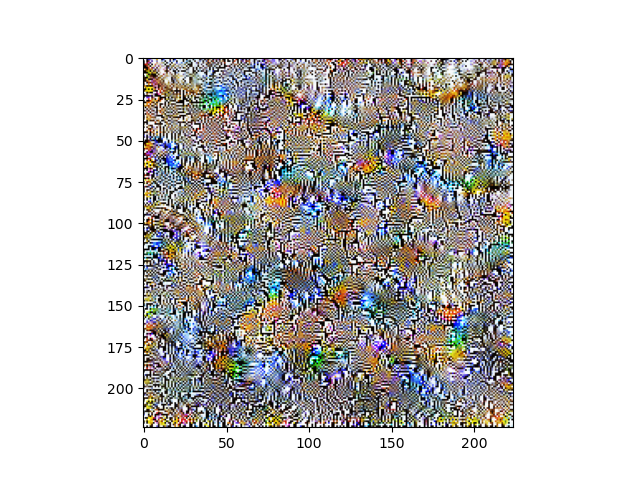

In [5]:
#Pick some filter and generate a tuning pattern

obj = objectives.Channel(model, conv_layers[LAYER].name, F)
transforms = transformations.default_list

input_img = render.render_vis(obj, 224, transforms=transforms, steps=(100 ,), optimizer=tf.keras.optimizers.Adam(0.05), freq_decay=.125, rgb_corr=True, display_plots=False, display_img=True)[0]

fig = plt.figure()

plt.imshow(input_img);


In [6]:
#pass the image through the network, and measure the channels that fired the most

layer_num = model.layers.index(conv_layers[LAYER])
print(layer_num)
layer_num_p = layer_num-1

modified_model = Model(
	model.inputs, [model.layers[layer_num_p].output, model.layers[layer_num].output, model.output]
)

f2, f1, preds = modified_model(tf.expand_dims(input_img, axis=0), training=False)
f2_mean_act = tf.math.reduce_mean(f2, axis=(0,1,2))


17


(3, 3, 512, 512)
(512,)


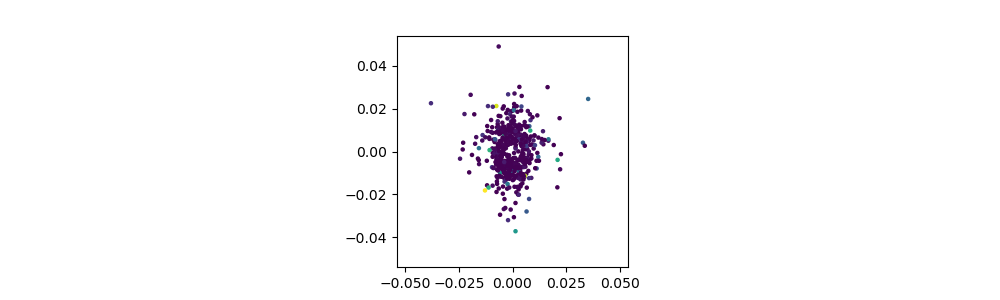

Clicked point: (-0.01, 0.05)
Color value: 0.33
Clicked point: (-0.04, 0.02)
Color value: 1.54
Clicked point: (-0.01, -0.02)
Color value: 12.29
Clicked point: (0.00, -0.04)
Color value: 6.57
Clicked point: (0.00, -0.04)
Color value: 6.57
Clicked point: (0.00, -0.04)
Color value: 6.57
Clicked point: (0.00, -0.04)
Color value: 6.57
Clicked point: (0.00, -0.04)
Color value: 6.57
Clicked point: (0.00, -0.04)
Color value: 6.57
Clicked point: (-0.01, 0.05)
Color value: 0.33
Clicked point: (-0.02, 0.03)
Color value: 0.29
Clicked point: (-0.02, 0.03)
Color value: 0.29
Clicked point: (-0.01, 0.02)
Color value: 1.53
Clicked point: (-0.01, 0.02)
Color value: 11.49
Clicked point: (-0.00, 0.02)
Color value: 0.00
Clicked point: (-0.01, 0.02)
Color value: 11.49
Clicked point: (-0.01, 0.02)
Color value: 11.49
Clicked point: (-0.00, 0.02)
Color value: 0.00
Clicked point: (-0.01, -0.02)
Color value: 12.29
Clicked point: (-0.01, -0.02)
Color value: 12.29
Clicked point: (-0.01, -0.02)
Color value: 0.00
Cli

In [15]:
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1


fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act)

ax.scatter(x,y, c=color, cmap = 'viridis', s=5)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

# Function to get information about clicked point
def on_click(event):
    # Get the coordinates of the clicked point
    x_click, y_click = event.xdata, event.ydata
    
    # If click is outside the axis limits, ignore
    if x_click is None or y_click is None:
        return
    
    # Find the nearest data point to the click
    distances = np.sqrt((x - x_click)**2 + (y - y_click)**2)
    closest_index = np.argmin(distances)
    
    # Display information about the clicked point
    print(f"Clicked point: ({x[closest_index]:.2f}, {y[closest_index]:.2f})")
    print(f"Color value: {f2_mean_act[closest_index]:.2f}")

fig.canvas.mpl_connect('button_press_event', on_click)


plt.show();


In [8]:
#top10Fprev=topKfilters(model, l_num-1, k=20)
filtersLprev = get_filter(model, LAYER-1)#[:,:,:,top10Fprev]
filtersL = get_filter(model, LAYER)#[:,:,:,top10F]
filtersL = filtersL


print("FL", filtersL.shape)

# Get kernels magnitude and theta for layer L-1
sp, ap = getSymAntiSymTF(filtersLprev)
e_ap = reduce_euclidean_norm(ap, axis=[0,1])**2
e_sp = reduce_euclidean_norm(sp, axis=[0,1])**2
betap = e_ap/(e_ap+e_sp)

# Get kernels magnitude and theta for layer L-1
sp, ap = getSymAntiSymTF(filtersLprev)
e_ap = reduce_euclidean_norm(ap, axis=[0,1])**2
e_sp = reduce_euclidean_norm(sp, axis=[0,1])**2
betap = e_ap/(e_ap+e_sp)


# Get kernels magnitude and theta for layer L
s, a = getSymAntiSymTF(filtersL)
e_a = reduce_euclidean_norm(a, axis=[0,1])**2
e_s = reduce_euclidean_norm(s, axis=[0,1])**2
dc = np.sign(np.mean(filtersL, axis=(0,1)))
beta = e_a/(e_a+e_s)

cos_sim = []
m = []
weight = []

theta = getSobelTF(filtersL)
theta_F_prev = []
theta_F_prev = getDominantAngle(filtersLprev)
'''for i in range(filtersLprev.shape[-1]):
	theta_F_prev.append(get_F_angle(filtersLprev[:,:,:,i]))
theta_F_prev = np.array(theta_F_prev)'''
for i in range(filtersL.shape[-1]):
	obj = objectives.Channel(model, conv_layers[LAYER].name, i)
	transforms = transformations.default_list

	input_img = render.render_vis(obj, 448, transforms=transforms, steps=(50 ,), optimizer=tf.keras.optimizers.Adam(0.05), freq_decay=.1250, rgb_corr=True, display_plots=False)[0]
	f2, f1, preds = modified_model(tf.expand_dims(input_img, axis=0), training=False)
	top_channels = np.argsort(f2_mean_act)[:20]
	f2_mean_act = matplotlib.colors.Normalize(vmin=0)(tf.math.reduce_mean(f2, axis=(0,1,2)).numpy()[top_channels])
	#f2_mean_act = f2_mean_act
	#: = tf.where(tf.greater(dc[:, i],0))[:,0].numpy()
	#mag = (a_mag[:,i]**2 - reduce_min(a_mag[:,i]**2 , axis=0, keepdims=True))/(reduce_max(a_mag[:,i]**2 , axis=0, keepdims=True) - reduce_min(a_mag[:,i]**2 , axis=0, keepdims=True))
	#print((theta_F_prev[:] - theta[:,i]).shape, mag.shape )
	cos_sim.extend(theta_F_prev[top_channels] - theta[top_channels,i])#(np.cos(theta_F_prev - theta[i,:])))
	m.extend(f2_mean_act.data)
	weight.extend(beta.numpy()[top_channels, i])
weight = np.array(weight)
m = np.array(m)


FL (3, 3, 512, 512)


ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 448, 448, 3)

(-3.141425609588623, 3.1395232677459717)
-3.141592653589793
['-$\\pi$', '0', '$\\pi$']


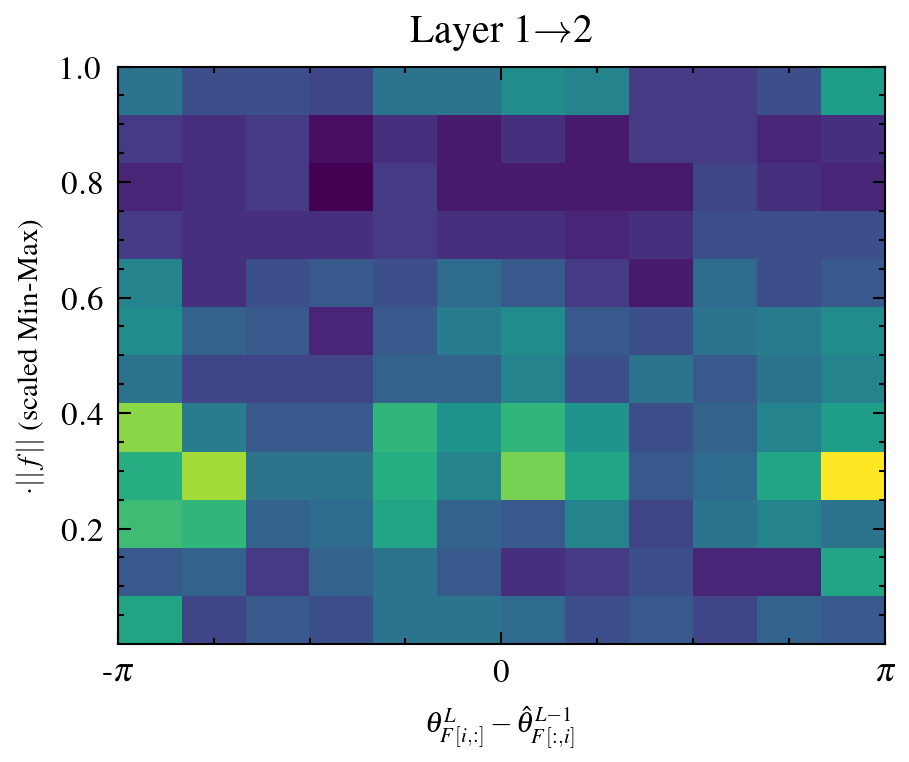

In [15]:
fig, ax= plt.subplots(1,1)

data = np.array(cos_sim)
data  = np.arctan2(np.sin(data), np.cos(data)) # (np.array(cos_sim) + np.pi) % (2 * np.pi) - np.pi
ax.hist2d(data,m, bins=12)
print(ax.get_xlim())
data_min, data_max = np.min(data), np.max(data)

# Set the tick marks at intervals of π
tick_min = np.floor(data_min / np.pi) * np.pi  # Start at the lowest multiple of π
tick_max = np.ceil(data_max / np.pi) * np.pi    # End at the highest multiple of π
ticks = np.arange(tick_min, tick_max + np.pi, np.pi)  # Ticks spaced by π
print(tick_min)
# Format tick labels with π notation
labels = [f"{int(t / np.pi)}π" if t != 0 else "0" for t in ticks]
labels = [label.replace("π", "$\\pi$").replace("1$\\pi$", "$\\pi$") for label in labels]
print(labels)
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels)




#ax.convert_xunits(radians)
ax.set_ylabel(r"$\cdot ||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)
ax.set_title(f"Layer {LAYER}"+r"$\rightarrow$"+f"{LAYER+1}")


plt.show() 

(array([118.,  92.,  73.,  58.,  55.,  75.,  97.,  77.,  96.,  75.,  68.,
         53.,  66.,  75.,  87., 115.]),
 array([-3.1414256e+00, -2.7488663e+00, -2.3563070e+00, -1.9637477e+00,
        -1.5711884e+00, -1.1786290e+00, -7.8606975e-01, -3.9351046e-01,
        -9.5117092e-04,  3.9160812e-01,  7.8416741e-01,  1.1767267e+00,
         1.5692861e+00,  1.9618454e+00,  2.3544047e+00,  2.7469640e+00,
         3.1395233e+00], dtype=float32),
 <BarContainer object of 16 artists>)

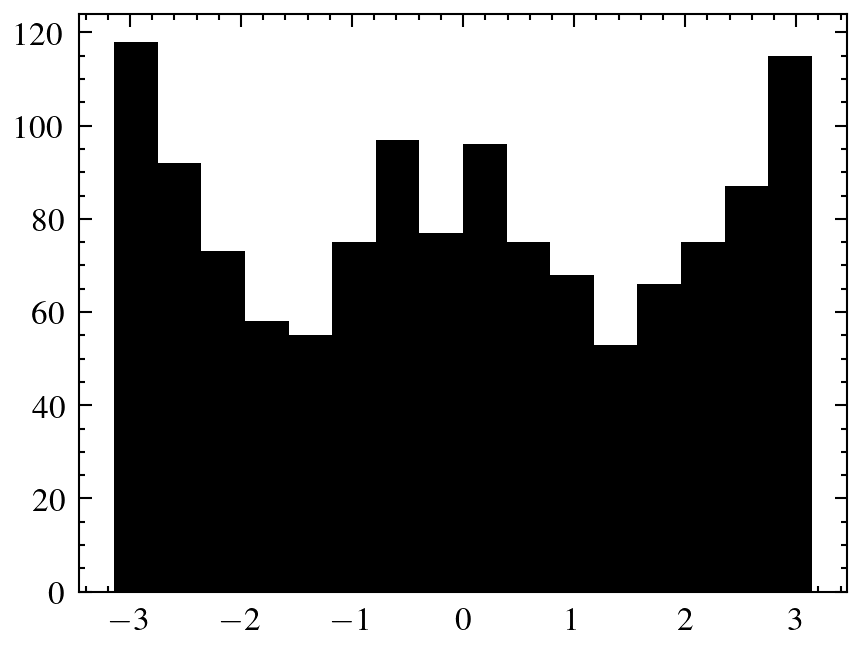

In [17]:
plt.hist(data, bins=16)